In [2]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import helper_functions.displayFunctions as display
import helper_functions.homogeneityMetrics as homogeneity

# Loading Predictions

In [3]:
with open('predictions/saved_predictions.pkl', 'rb') as f:
    results = pickle.load(f)

box_matches = pd.read_csv('data_out/object_detection/box_matches.csv', index_col=0)
participant_boxes = pd.read_csv('data/experiment_boxes.csv')

# Loading row

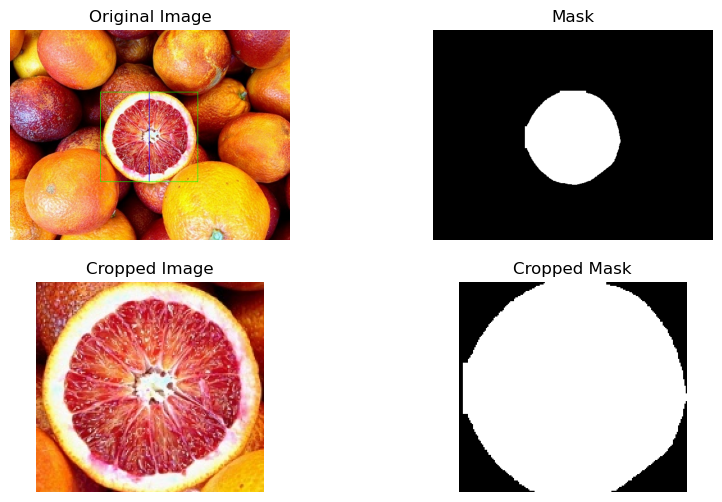

In [4]:
# image_name = 'MIRFLICKR25 - im12013.jpg' # 1 element
# image_name = 'COCO - 000000372250.jpg'     # 2 elements (0)
# image_name = 'CAT2000 -195.jpg'            # 0 elements

# image_name = 'COCO - 000000150237.jpg'        #testing (3)

# image_name = 'COCO - 000000011336.jpg'
image_name = 'COCO - 000000349425.jpg'

row_idx = 3

mask = results[image_name].masks[0].data.cpu().numpy()[0]
mask = cv2.resize(mask, (results[image_name].orig_shape[1], results[image_name].orig_shape[0]), interpolation=cv2.INTER_NEAREST).astype(np.uint8)

image = cv2.imread('images/images_nat/' + image_name)

df_image = participant_boxes[participant_boxes['file_name'] == image_name]
row = df_image.iloc[row_idx]

cropped_img = display.crop_image(image, row)
cropped_mask = display.crop_image(mask, row)

display_img = image.copy()
display.drawBB(display_img, row)

fig, ax = plt.subplots(2, 2, figsize=(10, 6))

ax[0, 0].imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(mask, cmap='gray')
ax[0, 1].set_title('Mask')
ax[0, 1].axis('off')

ax[1, 0].imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
ax[1, 0].set_title('Cropped Image')
ax[1, 0].axis('off')

ax[1, 1].imshow(cropped_mask, cmap='gray')
ax[1, 1].set_title('Cropped Mask')
ax[1, 1].axis('off')

plt.show()


## Examples of object-box matches.

In [5]:
# img_num = 0
# row_idx = 0

# image_files = os.listdir('images/images_nat')

# image_name = image_files[img_num]

# image = cv2.imread('images/images_nat/' + image_name)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# mask = results[image_name].masks[0].data.cpu().numpy()[0]
# mask = cv2.resize(mask, (results[image_name].orig_shape[1], results[image_name].orig_shape[0]), interpolation=cv2.INTER_NEAREST).astype(np.uint8)


# plt.imshow(image)



# Homogeneity Series

We iteratively increase the size of the box by 1 pixel and record the homogeneities

In [6]:
def is_bbox_outside_image(row, img_shape):
    """
    Check if any point of the bounding box is outside the image boundaries.
    Parameters:
    row (pd.Series): A row from a DataFrame containing bounding box information.
    img_shape (tuple): A tuple representing the shape of the image (height, width).
    Returns:
    bool: True if any point of the bounding box is outside the image boundaries, False otherwise.
    """
    box_points = display.getBBPoints(row)
    for point in box_points:
        if point[0] < 0 or point[1] < 0 or point[0] > img_shape[1] or point[1] > img_shape[0]:
            return True
        
    return False

def get_homogeneity_series(mask, row):
    """
    Calculate various homogeneity metrics for a given mask and image row.
    Parameters:
    mask (numpy.ndarray): The binary mask to be used for calculations.
    row (pandas.Series): A row from a DataFrame containing image metadata, including 'file_name', 'width_box', and 'height_box'.
    Returns:
    dict: A dictionary containing lists of calculated homogeneity metrics:
        - 'rms': List of Root Mean Square (RMS) values.
        - 'glcm': List of Gray Level Co-occurrence Matrix (GLCM) values.
        - 'otsus': List of Otsu's thresholding method values.
        - 'edge_density': List of edge density values.
    """
    image = cv2.imread(display.getImgPath(row['file_name']))
    mask = cv2.bitwise_not(mask)
    mask -= 254
    
    rmss = []
    glcms = []
    otsus = []
    edge_densities = []

    row_copy = row.copy()

    while not is_bbox_outside_image(row_copy, image.shape):
        row_copy['width_box'] += 1
        row_copy['height_box'] += 1

        cropped_img = display.crop_image(image, row_copy)
        cropped_mask = display.crop_image(mask, row_copy)

        rmss.append(homogeneity.rms(cropped_img, cropped_mask))
        glcms.append(homogeneity.glcm(cropped_img, cropped_mask))
        otsus.append(homogeneity.otsus_method(image, cropped_mask, row_copy))
        edge_densities.append(homogeneity.edge_density(image, cropped_mask, row_copy))

    return {
        'rms': rmss,
        'glcm': glcms,
        'otsus': otsus,
        'edge_density': edge_densities
    }

def get_homogeneity_series_rmss_only(mask, row):
    """
    Calculate the Root Mean Square (RMS) homogeneity series for a given mask and row.
    This function reads an image based on the file name in the provided row, inverts the mask,
    and iteratively increases the bounding box dimensions to calculate the RMS homogeneity
    for each cropped image and mask until the bounding box is outside the image.
    Args:
        mask (numpy.ndarray): The binary mask to be processed.
        row (pandas.Series): A pandas Series containing the image metadata, including the file name
                             and bounding box dimensions.
    Returns:
        dict: A dictionary containing the RMS homogeneity series with the key 'rms'.
    """

    image = cv2.imread(display.getImgPath(row['file_name']))
    mask = cv2.bitwise_not(mask)
    mask -= 254
    
    rmss = []
    row_copy = row.copy()

    while not is_bbox_outside_image(row_copy, image.shape):
        row_copy['width_box'] += 1
        row_copy['height_box'] += 1

        cropped_img = display.crop_image(image, row_copy)
        cropped_mask = display.crop_image(mask, row_copy)

        rmss.append(homogeneity.rms(cropped_img, cropped_mask))

    return {
        'rms': rmss
    }

metrics = get_homogeneity_series(mask, row)

## Visualize results

### Graphs

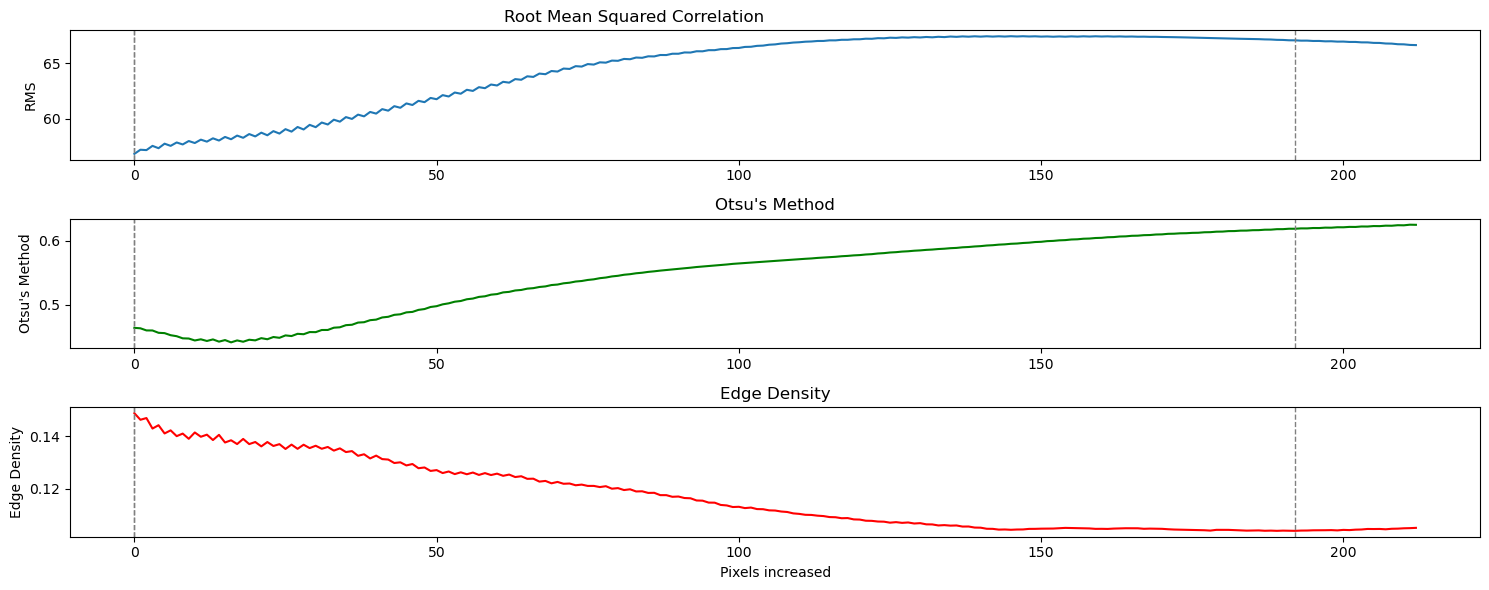

In [7]:
rmss = metrics['rms']
glcms = metrics['glcm']
otsus = metrics['otsus']
edge_densities = metrics['edge_density']

fig, ax = plt.subplots(3, 1, figsize=(15, 6))
ax[0].plot(rmss, label='RMS')
ax[0].title.set_position([0.4, 3])
ax[0].set_title('Root Mean Squared Correlation')
ax[0].set_ylabel('RMS')

ax[1].plot(otsus, label='Otsu\'s Method', color='green')
ax[1].set_title('Otsu\'s Method')
ax[1].set_ylabel('Otsu\'s Method')
# ax[2].legend()
ax[2].plot(edge_densities, label='Edge Density', color='red')
ax[2].set_title('Edge Density')
ax[2].set_xlabel('Pixels increased')
ax[2].set_ylabel('Edge Density')
# ax[3].legend()


min_rmss_index = rmss.index(min(rmss))
min_edge_density_index = edge_densities.index(min(edge_densities))
max_otsus = otsus.index(max(otsus))
x = [0, min_rmss_index, min_edge_density_index]

for axis in ax:
    for i in x:
        axis.axvline(x=i, color='gray', linestyle='--', linewidth=1, label=f'Line {chr(97 + x.index(i))}')

plt.tight_layout()
plt.show()

### Image

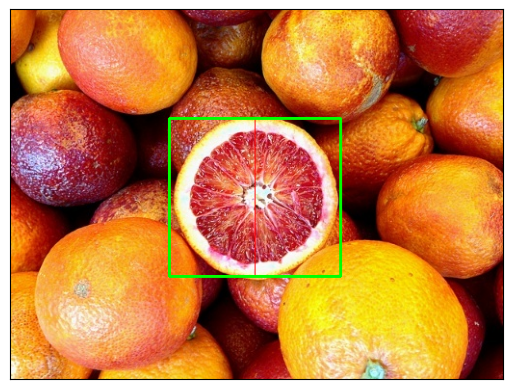

In [8]:
i = 0
row_copy = row.copy()

row_copy['width_box'] += x[i]
row_copy['height_box'] += x[i]

enlarged_box =  cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
display.drawBB(enlarged_box, row_copy, thicknessRectangle=2)

plt.imshow(enlarged_box)
plt.yticks([])
plt.xticks([])

plt.show()

# Compute Dataset

In [9]:
def compute_biggest_box_dataset(participant_boxes, box_matches, predictions):
    
    box_ids = []
    min_rmss_index = []
    max_rmss_index = []
    # min_glcm_index = []
    # max_glcm_index = []
    # min_otsus_index = []
    # max_otsus_index = []
    # min_edge_density_index = []
    # max_edge_density_index = []

    for _, match in tqdm(box_matches.iterrows(), total=len(box_matches)):
        # Getting row 
        row = participant_boxes.iloc[match['box_id']]
        prediction_id = match['match_id']

        #Getting image
        image_name = row['file_name']
        image = cv2.imread(display.getImgPath(image_name))

        # Skipping boxes outside image
        if is_bbox_outside_image(row, image.shape):
            continue

        # Getting mask
        mask = predictions[image_name].masks[prediction_id].data.cpu().numpy()[0]
        mask = cv2.resize(mask, (predictions[image_name].orig_shape[1], predictions[image_name].orig_shape[0]), interpolation=cv2.INTER_NEAREST).astype(np.uint8)

        # Getting biggest box
        metrics = get_homogeneity_series_rmss_only(mask, row)

        box_ids.append(match['box_id'])
        min_rmss_index.append(metrics['rms'].index(min(metrics['rms'])))
        max_rmss_index.append(metrics['rms'].index(max(metrics['rms'])))
        # min_glcm_index.append(metrics['glcm'].index(min(metrics['glcm'])))
        # max_glcm_index.append(metrics['glcm'].index(max(metrics['glcm'])))
        # min_otsus_index.append(metrics['otsus'].index(min(metrics['otsus'])))
        # max_otsus_index.append(metrics['otsus'].index(max(metrics['otsus'])))
        # min_edge_density_index.append(metrics['edge_density'].index(min(metrics['edge_density'])))
        # max_edge_density_index.append(metrics['edge_density'].index(max(metrics['edge_density'])))
    
    biggest_box = pd.DataFrame({
        'box_id': box_ids,
        'min_rmss_index': min_rmss_index,
        'max_rmss_index': max_rmss_index,
        # 'min_glcm_index': min_glcm_index,
        # 'max_glcm_index': max_glcm_index,
        # 'min_otsus_index': min_otsus_index,
        # 'max_otsus_index': max_otsus_index,
        # 'min_edge_density_index': min_edge_density_index,
        # 'max_edge_density_index': max_edge_density_index
    })

    return biggest_box

compute = False

match_threshold = 0.4
matches = box_matches[box_matches['dice_score'] > match_threshold]
# matches = matches[matches['experiment'].isin([3, 4])]

matches

# if compute:
#     biggest_box = compute_biggest_box_dataset(participant_boxes, matches, results)
#     biggest_box.to_csv('data_out/object_detection/biggest_homogeneus_box.csv')
# else:
#     biggest_box = pd.read_csv('data_out/object_detection/biggest_homogeneus_box.csv', index_col=0)

# biggest_box

,box_id,match_id,dice_score,iou,detected_class,confidence_score,experiment
2,2,2,0.618767,0.442655,chair,0.604875,2
13,13,1,0.552700,0.379242,apple,0.450845,2
16,16,0,0.704578,0.537121,vase,0.480154,2
23,23,1,0.827765,0.697510,car,0.846642,3
26,26,0,0.810113,0.676949,cup,0.293640,3
...,...,...,...,...,...,...,...
39214,39214,0,0.917906,0.840271,vase,0.698922,2
39215,39215,2,0.762136,0.611206,potted plant,0.285963,2
39217,39217,0,0.451132,0.289994,chair,0.885056,2
39242,39242,0,0.812516,0.670098,vase,0.835145,2


## Adding more info to the table

In [10]:
# def add_info_biigest_box(biggest_box, participant_boxes):
#     initial_size = []
#     enlarged_size = []
#     perc_increases = []

#     for _,box in tqdm(biggest_box.iterrows(), total=len(biggest_box)):
#         row = participant_boxes.iloc[int(box['box_id'])]
#         initial_size.append(row['width_box'] * row['height_box'])
#         enlarged_size.append((row['width_box'] + box['min_rmss_index']) * (row['height_box'] + box['min_rmss_index']))
#         perc_increases.append((enlarged_size[-1] - initial_size[-1]) / initial_size[-1])

#     biggest_box['initial_size'] = initial_size
#     biggest_box['enlarged_size'] = enlarged_size
#     biggest_box['perc_increase'] = perc_increases

#     return biggest_box

# biggest_box = add_info_biigest_box(biggest_box, participant_boxes)
# biggest_box.to_csv('data_out/object_detection/biggest_homogeneus_box.csv')

In [11]:
def get_homogeneity_series_single_axis(mask, row, axis):
    image = cv2.imread(display.getImgPath(row['file_name']))
    mask = cv2.bitwise_not(mask)
    mask -= 254

    rmss = []
    row_copy = row.copy()

    while not is_bbox_outside_image(row_copy, image.shape):
        if axis == 'horizontal':
            row_copy['width_box'] += 1
        elif axis == 'vertical':
            row_copy['height_box'] += 1

        cropped_img = display.crop_image(image, row_copy)
        cropped_mask = display.crop_image(mask, row_copy)

        rmss.append(homogeneity.rms(cropped_img, cropped_mask))

    return {
        'rms': rmss
    }

    
horizontal_axis = get_homogeneity_series_single_axis(mask, row, 'horizontal')
vertical_axis = get_homogeneity_series_single_axis(mask, row, 'vertical')


# LAST VERSION

False


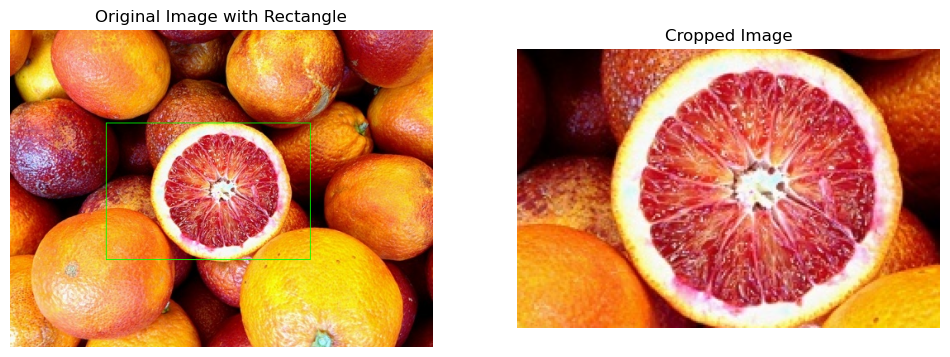

In [12]:
def get_increased_box_cropped_points(row, amount_up, amount_down, axis, integers: bool = True):
    width = row['width_box']
    height = row['height_box']
    centerX = row['centerX']
    centerY = row['centerY']
    rotation = row['rotation']

    # Calculating the bounding box
    pts = [[centerX-width/2 , centerY-height/2], [centerX+width/2 , centerY-height/2], 
           [centerX+width/2 , centerY+height/2], [centerX-width/2 , centerY+height/2]]

    if axis == 'vertical':
        pts[2][1] += amount_down
        pts[3][1] += amount_down
    if axis == 'horizontal':
        pts[1][0] += amount_down
        pts[2][0] += amount_down
    if axis == 'vertical':
        pts[0][1] -= amount_up
        pts[1][1] -= amount_up
    if axis == 'horizontal':
        pts[0][0] -= amount_up
        pts[3][0] -= amount_up

    # Rotating box
    oldcenter = (centerX, centerY)
    rotation_matrix = cv2.getRotationMatrix2D(oldcenter, -rotation, 1)
    
    rotated_pts = []
    for keypoint in pts:
        rotatedPoint = rotation_matrix.dot(np.array(keypoint + [1,]))
        rotated_pts.append([rotatedPoint[0],rotatedPoint[1]])

    # Return integers if needed
    if integers:
        intPoints = []
        for pt in rotated_pts: 
            intPoints.append([round(pt[0]), round(pt[1])])
        return intPoints

    return rotated_pts

def points_outside_image(points, img_shape):
    for point in points:
        if point[0] < 0 or point[1] < 0 or point[0] > img_shape[1] or point[1] > img_shape[0]:
            return True
    return False

def crop_img_pts(row, image, amount_up, amount_down, axis,):

    width = row['width_box']
    height = row['height_box']
    centerX = row['centerX']
    centerY = row['centerY']
    rotation = row['rotation']

     # Calculating the bounding box
    pts = [[centerX-width/2 , centerY-height/2], [centerX+width/2 , centerY-height/2], 
           [centerX+width/2 , centerY+height/2], [centerX-width/2 , centerY+height/2]]
    
    if axis == 'vertical':
        pts[2][1] += amount_down
        pts[3][1] += amount_down
    if axis == 'horizontal':
        pts[1][0] += amount_down
        pts[2][0] += amount_down
    if axis == 'vertical':
        pts[0][1] -= amount_up
        pts[1][1] -= amount_up
    if axis == 'horizontal':
        pts[0][0] -= amount_up
        pts[3][0] -= amount_up

    width = abs(pts[1][0] - pts[0][0])
    height = abs(pts[2][1] - pts[1][1])

    # Rotating and cropping image
    rotationMatrix = cv2.getRotationMatrix2D((centerX,centerY),rotation,1)
    image = cv2.warpAffine(image,rotationMatrix,(image.shape[1], image.shape[0]))
    image = image[int(pts[0][1]):int(pts[0][1])+int(height), int(pts[0][0]):int(pts[0][0]+width)]

    return image

up = 50
down = 20

ptsssss = get_increased_box_cropped_points(row, up, down, 'horizontal')
print(points_outside_image(ptsssss, image.shape))
disp = image.copy()
display.drawRectangle(disp, ptsssss)
cropped_pts = crop_img_pts(row, image, up, down, 'horizontal')


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(cv2.cvtColor(disp, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image with Rectangle')
ax[0].axis('off')

ax[1].imshow(cv2.cvtColor(cropped_pts, cv2.COLOR_BGR2RGB))
ax[1].set_title('Cropped Image')
ax[1].axis('off')

plt.show()

In [13]:
def get_max_homogeneity_single_axis_V2(mask, row, axis):
    image = cv2.imread(display.getImgPath(row['file_name']))
    mask = cv2.bitwise_not(mask)
    mask -= 254

    if (row['axis'] == 'vertical_axis' and axis == 'vertical') or (row['axis'] == 'horizontal_axis' and axis == 'horizontal'):
        rmss_up = []
        rmss_down = []
        increaseUp = 0
        increaseDown = 0
        pts = get_increased_box_cropped_points(row, increaseUp, increaseDown, axis)
        while not points_outside_image(pts, image.shape):
            cropped_img = crop_img_pts(row, image, increaseUp, increaseDown, axis)
            cropped_mask = crop_img_pts(row, mask, increaseUp, increaseDown, axis)
            rmss_up.append(homogeneity.rms(cropped_img, cropped_mask))
            increaseUp += 1
            pts = get_increased_box_cropped_points(row, increaseUp, increaseDown, axis)

        increaseUp = 0
        increaseDown = 0
        pts = get_increased_box_cropped_points(row, increaseUp, increaseDown, axis)
        while not points_outside_image(pts, image.shape):
            cropped_img = crop_img_pts(row, image, increaseUp, increaseDown, axis)
            cropped_mask = crop_img_pts(row, mask, increaseUp, increaseDown, axis)
            rmss_down.append(homogeneity.rms(cropped_img, cropped_mask))
            increaseDown += 1
            pts = get_increased_box_cropped_points(row, increaseUp, increaseDown, axis)

        min_index_up = rmss_up.index(min(rmss_up))
        min_index_down = rmss_down.index(min(rmss_down))

        return {
            'up': min_index_up,
            'down': min_index_down
        }
    
    else:
        rmss = []
        row_copy = row.copy()

        while not is_bbox_outside_image(row_copy, image.shape):
            if axis == 'horizontal':
                row_copy['width_box'] += 1
            elif axis == 'vertical':
                row_copy['height_box'] += 1

            cropped_img = display.crop_image(image, row_copy)
            cropped_mask = display.crop_image(mask, row_copy)

            rmss.append(homogeneity.rms(cropped_img, cropped_mask))

        min_index = rmss.index(min(rmss))

        return{
            'up': int(min_index/2),
            'down': int(min_index/2)
        }


horizontal_increase = get_max_homogeneity_single_axis_V2(mask, row, 'horizontal')
vertical_increase = get_max_homogeneity_single_axis_V2(mask, row, 'vertical')

print(horizontal_increase)
print(vertical_increase)


{'up': 0, 'down': 0}
{'up': 31, 'down': 0}


In [14]:
def get_homogeneity_series_combined_increase(mask, row):
    initial = get_homogeneity_series_rmss_only(mask, row)

    second_increase_row = row.copy()
    min_index_combined = initial['rms'].index(min(initial['rms']))
    second_increase_row['width_box'] += min_index_combined
    second_increase_row['height_box'] += min_index_combined

    vertical_increase = get_max_homogeneity_single_axis_V2(mask, second_increase_row, 'vertical')
    horizontal_increase = get_max_homogeneity_single_axis_V2(mask, second_increase_row, 'horizontal')
    
    return {
        'general': min_index_combined,
        'vertical': vertical_increase,
        'horizontal': horizontal_increase
    }

increases = get_homogeneity_series_combined_increase(mask, row)

increases


{'general': 0,
 'vertical': {'up': 31, 'down': 0},
 'horizontal': {'up': 0, 'down': 0}}

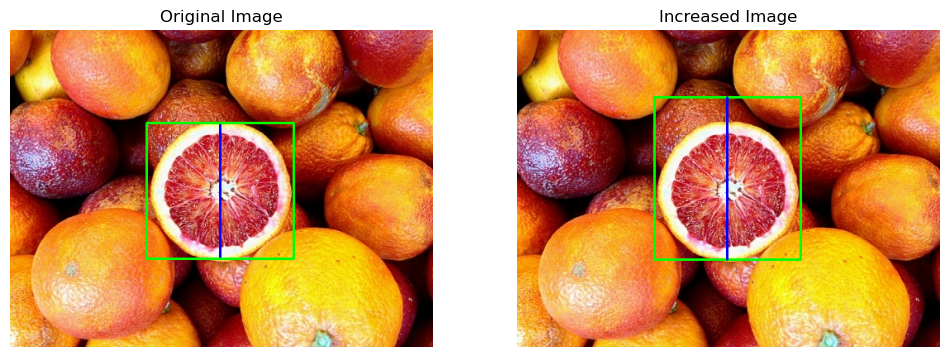

In [15]:
def display_increases(image, row, increases, thickness=2):
    disp = image.copy()
    row_copy = row.copy()

    row_copy['width_box'] += increases['general']
    row_copy['height_box'] += increases['general']

    if increases['vertical']['up']+increases['vertical']['down'] > increases['horizontal']['up']+increases['horizontal']['down']:
        pts = get_increased_box_cropped_points(row_copy, increases['vertical']['up'], increases['vertical']['down'], 'vertical')
    else:
        pts = get_increased_box_cropped_points(row_copy, increases['horizontal']['up'], increases['horizontal']['down'], 'horizontal')
    
    display.drawRectangle(disp, pts, thickness=thickness)

    # Drawing symmetry axis
    if row['axis'] == "vertical_axis":
        startAxis = ((pts[0][0] + pts[1][0])/2  , (pts[0][1] + pts[1][1])/2)
        endAxis = ((pts[2][0] + pts[3][0])/2  , (pts[2][1] + pts[3][1])/2) 
    elif row['axis'] == "horizontal_axis":
        startAxis = ((pts[0][0] + pts[3][0])/2  , (pts[0][1] + pts[3][1])/2)
        endAxis = ((pts[1][0] + pts[2][0])/2  , (pts[1][1] + pts[2][1])/2)        
    else:
        print(row['axis'])
    cv2.line(disp, (int(startAxis[0]),int(startAxis[1])), (int(endAxis[0]),int(endAxis[1])), [255,0,0], thickness)

    return disp

increased = display_increases(image, row, increases)
original = image.copy()
original = display.drawBB(original, row, thicknessAxis=2, thicknessRectangle=2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(cv2.cvtColor(increased, cv2.COLOR_BGR2RGB))
ax[1].set_title('Increased Image')
ax[1].axis('off')

plt.show()

## DOING THE WHOLE DATASET

In [16]:
def compute_biggest_box_dataset(participant_boxes, box_matches, predictions):
    
    box_ids = []
    original_areas = []
    new_areas = []
    perc_increases = []

    errors = 0
    for _, match in tqdm(box_matches.iterrows(), total=len(box_matches)):
        # Getting row 
        row = participant_boxes.iloc[match['box_id']]
        prediction_id = match['match_id']

        #Getting image
        image_name = row['file_name']
        image = cv2.imread(display.getImgPath(image_name))

        # Skipping boxes outside image
        if is_bbox_outside_image(row, image.shape):
            continue

        # Getting mask
        mask = predictions[image_name].masks[prediction_id].data.cpu().numpy()[0]
        mask = cv2.resize(mask, (predictions[image_name].orig_shape[1], predictions[image_name].orig_shape[0]), interpolation=cv2.INTER_NEAREST).astype(np.uint8)

        # Getting biggest box
        try:
            increases = get_homogeneity_series_combined_increase(mask, row)
        except:
            errors += 1
            continue

        # Calculating metrics
        original_area = row['width_box'] * row['height_box']
        
        new_width = row['width_box'] + increases['general']
        new_height = row['height_box'] + increases['general']
        if increases['vertical']['up']+increases['vertical']['down'] > increases['horizontal']['up']+increases['horizontal']['down']:
            new_width = row['width_box'] + increases['vertical']['up'] + increases['vertical']['down']
        else:
            new_height = row['height_box'] + increases['horizontal']['up'] + increases['horizontal']['down']
        new_area = new_width * new_height

        perc_increase = (new_area - original_area) / original_area

        box_ids.append(match['box_id'])
        original_areas.append(original_area)
        new_areas.append(new_area)
        perc_increases.append(perc_increase)

    
    biggest_box = pd.DataFrame({
        'box_id': box_ids,
        'original_area': original_areas,
        'new_area': new_areas,
        'perc_increase': perc_increases
    })

    print(f'Errors: {errors}')
    return biggest_box

compute = False
if compute:
    biggest_box = compute_biggest_box_dataset(participant_boxes, matches, results)
    biggest_box.to_csv('data_out/object_detection/biggest_homogeneus_box_V2.csv')
else:
    biggest_box = pd.read_csv('data_out/object_detection/biggest_homogeneus_box_V2.csv', index_col=0)

In [17]:
biggest_box

,box_id,original_area,new_area,perc_increase
0,2,40361.999675,88101.999619,1.182796
1,13,20000.000000,46535.000000,1.326750
2,16,20000.000000,61846.000000,2.092300
3,23,40194.000000,65056.000000,0.618550
4,26,71262.000000,78003.000000,0.094595
...,...,...,...,...
6566,39214,23660.000000,72570.000000,2.067202
6567,39215,27224.000000,67404.000000,1.475904
6568,39217,55400.000000,74692.000000,0.348231
6569,39242,8900.000331,10908.000334,0.225618


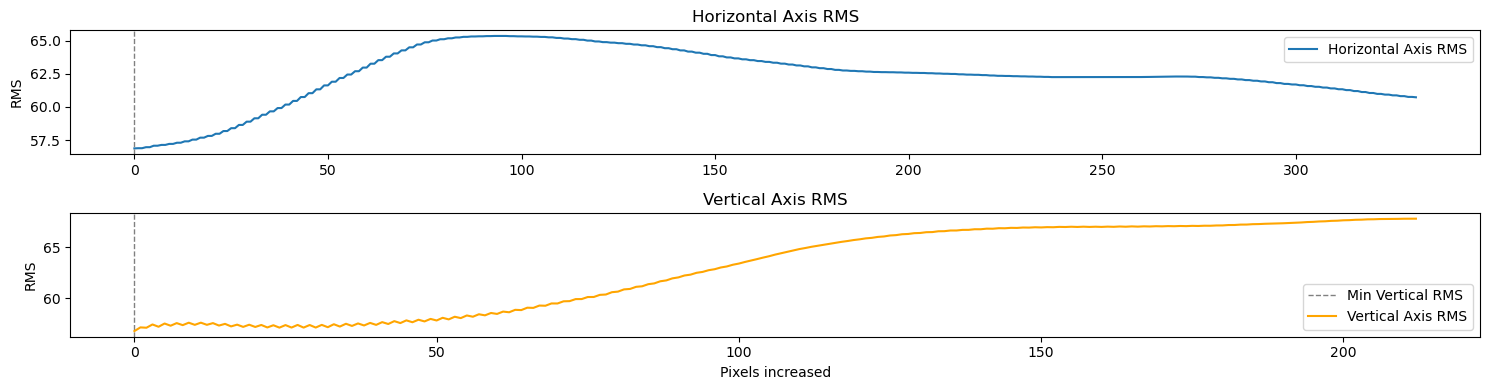

In [18]:
# Plotting the horizontal_axis and vertical_axis RMS values
fig, ax = plt.subplots(2, 1, figsize=(15, 4))

# Plot horizontal_axis RMS values
ax[0].plot(horizontal_axis['rms'], label='Horizontal Axis RMS')
ax[0].set_title('Horizontal Axis RMS')
ax[0].set_ylabel('RMS')
ax[0].legend()
min_horizontal_index = horizontal_axis['rms'].index(min(horizontal_axis['rms']))
min_vertical_index = vertical_axis['rms'].index(min(vertical_axis['rms']))

ax[0].axvline(x=min_horizontal_index, color='gray', linestyle='--', linewidth=1, label='Min Horizontal RMS')
ax[1].axvline(x=min_vertical_index, color='gray', linestyle='--', linewidth=1, label='Min Vertical RMS')

# Plot vertical_axis RMS values
ax[1].plot(vertical_axis['rms'], label='Vertical Axis RMS', color='orange')
ax[1].set_title('Vertical Axis RMS')
ax[1].set_xlabel('Pixels increased')
ax[1].set_ylabel('RMS')
ax[1].legend()

plt.tight_layout()
plt.show()

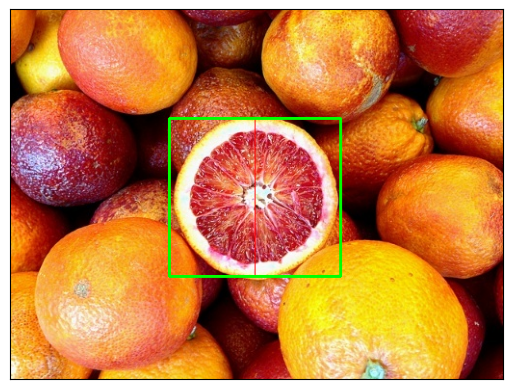

In [19]:
def display_increase_box(row, vertical_increase, horizontal_increase):
    row_copy = row.copy()
    row_copy['width_box'] += horizontal_increase
    row_copy['height_box'] += vertical_increase

    image = cv2.imread(display.getImgPath(row['file_name']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    display_img = image.copy()
    display.drawBB(display_img, row_copy, thicknessRectangle=2)

    plt.imshow(display_img)
    plt.yticks([])
    plt.xticks([])

    plt.show()

display_increase_box(row, 0, min_horizontal_index)

In [20]:
box_matches

,box_id,match_id,dice_score,iou,detected_class,confidence_score,experiment
0,0,0,0.145687,0.078124,person,0.898828,2
1,1,-1,0.000000,0.000000,NaN,0.000000,2
2,2,2,0.618767,0.442655,chair,0.604875,2
3,3,-1,0.000000,0.000000,NaN,0.000000,2
4,4,-1,0.000000,0.000000,NaN,0.000000,2
...,...,...,...,...,...,...,...
39249,39249,0,0.069947,0.035430,person,0.858416,2
39250,39250,0,0.866125,0.743869,bowl,0.420610,2
39251,39251,0,0.000000,0.000000,boat,0.433775,2
39252,39252,0,0.000000,0.000000,person,0.786977,2


In [22]:
img_num = 33
box_match_id = 0

if True:

    box_matches_slim = box_matches.merge(participant_boxes[['Index', 'file_name']], left_on='box_id', right_on='Index', how='left')
    box_matches_slim = box_matches_slim[box_matches_slim['dice_score'] >= 0.4]

    image_file_names = os.listdir('images/images_nat')
    file_name = image_file_names[img_num]
    box_matches_img = box_matches_slim[box_matches_slim['file_name'] == file_name]

    match_row = box_matches_img.iloc[box_match_id]
    row = participant_boxes.iloc[match_row['box_id']]

    image = cv2.imread(display.getImgPath(file_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    display_img = image.copy()
    display.drawBB(display_img, row, thicknessRectangle=2, thicknessAxis=2)

    mask = results[file_name].masks[match_row['match_id']].data.cpu().numpy()[0]
    mask = cv2.resize(mask, (results[file_name].orig_shape[1], results[file_name].orig_shape[0]), interpolation=cv2.INTER_NEAREST).astype(np.uint8)
    increases = get_homogeneity_series_combined_increase(mask, row)

    increase_disp = display_increases(image, row, increases)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(display_img)
    ax[0].set_title('Original Bounding Box')
    ax[0].axis('off')

    ax[1].imshow(increase_disp)
    ax[1].set_title('Increased Bounding Box')
    ax[1].axis('off')

    plt.show()

SyntaxError: invalid syntax (3120167674.py, line 2)

In [ ]:
def get_next_prime_number(n):
    """
    Get the next prime number after a given number.
    Parameters:
    n (int): The number after which to find the next prime number.
    Returns:
    int: The next prime number after n.
    """
    def is_prime(num):
        if num < 2:
            return False
        for i in range(2, int(num ** 0.5) + 1):
            if num % i == 0:
                return False
        return True

    next_prime = n + 1
    while not is_prime(next_prime):
        next_prime += 1

    return next_prime

    def rotate_image(image, angle):
        """
        Rotate the given image by the specified angle.
        Parameters:
        image (numpy.ndarray): The image to be rotated.
        angle (float): The angle by which to rotate the image.
        Returns:
        numpy.ndarray: The rotated image.
        """
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)

        # Perform the rotation
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))

        return rotated